# Box 11.4 Figure 2

* Northern Hemisphere weather conditions in July 2018

Author: Mathias Hauser

In [1]:
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplotutils as mpu
import numpy as np
import xarray as xr
from matplotlib.patches import Ellipse

import conf
import filefinder as ff
from utils import plot

In [2]:
mpl.rcParams["font.sans-serif"] = "Arial"

## Helper functions

In [3]:
def load_era5_orig(varn, res="1m", year="*", expver=1, time=slice("1979", "2019")):

    fN = era5_orig.create_full_name(varn=varn, res=res, year=year)

    ds = xr.open_mfdataset(
        fN,
        combine="by_coords",
        coords="minimal",
        data_vars="minimal",
        compat="override",
        decode_cf=True,
        use_cftime=True,
    )

    ds = ds.rename(latitude="lat", longitude="lon")
    da = ds[varn]
    da = da.sel(time=time)

    if expver is not None and expver in da.dims:
        da = da.sel(expver=1)

    return da.load()


def get_months(da, start, end=None):

    if end is None:
        end = start

    time = da.time

    # select months
    sel = (time.dt.month >= start) & (time.dt.month <= end)

    return da.sel(time=sel).resample(time="A").mean()


def get_year_clim(da, year="2018", time=slice("1981", "2010")):

    year = da.sel(time=year)
    clim = da.sel(time=time).mean("time")

    return year, clim


def coarsen(da):
    return da.coarsen(lat=4, lon=4, boundary="trim").mean()

## Data

In [4]:
# filefinder for data in the data repo on exo

base = "/net/exo/landclim/data/dataset/ERA5_deterministic/recent"
era5_orig = ff.FileFinder(
    path_pattern=base + "/0.25deg_lat-lon_{res}/original",
    file_pattern="era5_deterministic_recent.{varn}.025deg.{res}.{year}.nc",
)

In [5]:
# load wind data

fN = "../data/ERA5/era5_deterministic_recent.uv200.025deg.1m.2018.nc"

winds = xr.open_dataset(fN)
winds = winds.rename(latitude="lat", longitude="lon")
windsc = coarsen(winds)

# u: positive is towards east
# v: positive is towards north

In [6]:
# load geopotential

fN = "../data/ERA5/era5_deterministic_recent.z200.025deg.1m.2018.nc"

geopotential = xr.open_dataset(fN).z
geopotential = geopotential.rename(latitude="lat", longitude="lon")

gph = geopotential / 9.81
gphc = coarsen(gph)

In [7]:
gphc_7_2018 = gphc.sel(time="2018-07").squeeze()
gphc_MMJA_2018 = gphc.sel(time=slice("2018-05", "2018-08")).mean("time")

**t2m**

In [8]:
t2m = load_era5_orig("t2m")
t2mc = coarsen(t2m)

In [9]:
t2mc_7 = get_months(t2mc, 7)
t2mc_7_2018, t2mc_7_clim = get_year_clim(t2mc_7)

t2mc_7_d = t2mc_7_2018 - t2mc_7_clim

In [10]:
t2mc_MJJA = get_months(t2mc, 5, 8)
t2mc_MJJA_2018, t2mc_MJJA_clim = get_year_clim(t2mc_MJJA)

t2mc_MJJA_d = t2mc_MJJA_2018 - t2mc_MJJA_clim

In [11]:
def plot_gph_contour(ax, da):

    levels_light = np.concatenate(
        [np.arange(10_500, 12_300, 100), np.arange(12_400, 12_500, 100)]
    )

    levels = [12_000, 12_300]

    h = da.plot.contour(
        ax=ax,
        levels=levels_light,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        linewidths=0.5,
        colors="0.1",
    )

    h = da.plot.contour(
        ax=ax,
        levels=levels,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        linewidths=2,
        colors="0.1",
    )

    ax.clabel(h, fmt="%1.0f", colors="0.1")

## Box 11.4 Figure 2

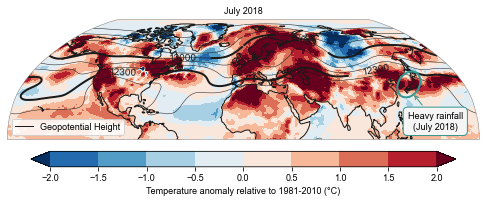

In [12]:
f, ax = plot.map_subplots()

# =====
# temperature and cbar

d = t2mc_7_d.sel(lat=slice(90, -2)).squeeze()
levels = np.arange(-2.0, 2.1, 0.5)
h = plot.one_map_flat(
    d, ax, robust=True, add_colorbar=False, levels=levels, plotfunc="contourf"
)

cbar = mpu.colorbar(h, ax, orientation="horizontal", shrink=0.1, pad=0.1, aspect=25)
cbar.ax.tick_params("both", labelsize=9)
cbar.set_label("Temperature anomaly relative to 1981-2010 (°C)", fontsize=9)

# =====
# add text and ellipse


jpn = 135, 31

a = ccrs.Robinson()
jpn_trans = a.transform_point(*jpn, ccrs.PlateCarree())

ax.annotate(
    "Heavy rainfall\n(July 2018)",
    jpn_trans,
    xycoords="data",
    size=9,
    xytext=(22.5, -28),
    ha="center",
    va="center",
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", linewidth=1, color="#35978f"),
    bbox=dict(facecolor="#f5f5f5", pad=0.5, ec="#35978f", lw=1, boxstyle="round"),
)

# =====
# add ellipse

jpn = 135, 37

a = ccrs.Robinson()
jpn_trans = a.transform_point(*jpn, ccrs.PlateCarree())

ellipse = Ellipse(
    xy=jpn_trans,
    width=3000000 / 2,
    height=5000000 / 2.5,
    edgecolor="#35978f",
    fc="None",
    lw=2,
    angle=-33,
    zorder=3,
)

ax.add_patch(ellipse)

# =====

# add contour lines
plot_gph_contour(ax, gphc_7_2018)
ax.plot([], [], linewidth=1, color="0.1", label="Geopotential Height")
ax.legend(fontsize=9, loc="lower left")

# =====

ax.set_title("July 2018", size=9)
ax.set_extent([-180, 180, 0, 90], ccrs.PlateCarree())

f.subplots_adjust(wspace=0.05, left=0.01, right=0.99, hspace=0.25, bottom=0.3, top=0.9)


mpu.set_map_layout(ax)

f.canvas.draw()

fN = conf.figure_filename("Box_11.4_Figure_2_2018", "Box_11.4_Figure_2_2018")

plt.savefig(fN + ".png", dpi=300, facecolor="w")
plt.savefig(fN + ".pdf", dpi=300, facecolor="w")